In [ ]:
pip install bertopic biopython umap-learn hdbscan

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

# Extracting 200 Research Papers

In [ ]:
from Bio import Entrez
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# email for NCBI access
Entrez.email = "rubaishaah.work@gmail.com"

def fetch_pubmed_abstracts_with_dates(query, max_results=100):
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
    record = Entrez.read(handle)
    id_list = record["IdList"]

    abstracts = []
    timestamps = []
    
    for pmid in id_list:
        try:
            fetch = Entrez.efetch(db="pubmed", id=pmid, rettype="medline", retmode="text")
            lines = fetch.read().split("\n")
            abstract = ""
            date = None
            for line in lines:
                if line.startswith("AB  - "):  # Abstract line
                    abstract += line[6:].strip() + " "
                elif line.startswith("DP  - "):  # Date Published
                    date = line[6:10]  # Extract just the year
            if abstract.strip():
                abstracts.append(abstract.strip())
                timestamps.append(date if date else "Unknown")
            time.sleep(0.2)
        except:
            continue

    return abstracts, timestamps

# Step 1: Fetch abstracts
abstracts, timestamps = fetch_pubmed_abstracts_with_dates("cancer AND inflammation", max_results=200)

# Step 2: Remove stop words
def preprocess_texts(texts):
    stop_words = set(stopwords.words('english'))
    cleaned_texts = []
    for text in texts:
        words = word_tokenize(re.sub(r"[^a-zA-Z\s]", "", text.lower()))  # Remove punctuation and lowercase
        filtered = [word for word in words if word not in stop_words]
        cleaned_texts.append(" ".join(filtered))
    return cleaned_texts

cleaned_abstracts = preprocess_texts(abstracts)

# Step 3: BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(cleaned_abstracts, show_progress_bar=True)

topic_model = BERTopic(language="english", verbose=True)
topics, probs = topic_model.fit_transform(cleaned_abstracts, embeddings)

# Step 4: Visualize
topic_model.visualize_barchart()


In [ ]:
import pandas as pd

# Get topic info
topic_info = topic_model.get_topic_info()

# Create a DataFrame with topic number and top words
topics_data = []

for topic_num in topic_info['Topic']:
    if topic_num == -1:
        continue  # -1 is usually outlier/noise
    words = topic_model.get_topic(topic_num)
    word_list = [word for word, _ in words]
    topics_data.append({
        "Topic": topic_num,
        "Top_Words": ", ".join(word_list)
    })

topics_df = pd.DataFrame(topics_data)

# Save to CSV
topics_df.to_csv("bertopic_topics.csv", index=False)


In [ ]:
print(f"Number of abstracts fetched: {len(abstracts)}")


# Extracting from 5000 Research papers

In [ ]:
from Bio import Entrez
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer


# Set email for NCBI
Entrez.email = "rubaishaah.work@gmail.com"

# Step 1: Fetch 5000 abstracts in batches
def fetch_pubmed_abstracts_with_dates(query, total_results=5000, batch_size=200):
    abstracts = []
    timestamps = []
    for ret_start in range(0, total_results, batch_size):
        try:
            handle = Entrez.esearch(db="pubmed", term=query, retmax=batch_size, retstart=ret_start)
            record = Entrez.read(handle)
            id_list = record["IdList"]

            for pmid in id_list:
                try:
                    fetch = Entrez.efetch(db="pubmed", id=pmid, rettype="medline", retmode="text")
                    lines = fetch.read().split("\n")
                    abstract = ""
                    date = None
                    for line in lines:
                        if line.startswith("AB  - "):
                            abstract += line[6:].strip() + " "
                        elif line.startswith("DP  - "):
                            date = line[6:10]
                    if abstract.strip():
                        abstracts.append(abstract.strip())
                        timestamps.append(date if date else "Unknown")
                    time.sleep(0.2)
                except:
                    continue
            time.sleep(1)
        except:
            continue
    return abstracts, timestamps

abstracts, timestamps = fetch_pubmed_abstracts_with_dates("cancer AND inflammation", total_results=5000)
print(f"Number of abstracts fetched: {len(abstracts)}")

# Step 2: Remove stop words
def preprocess_texts(texts):
    stop_words = set(stopwords.words('english'))
    cleaned_texts = []
    for text in texts:
        words = word_tokenize(re.sub(r"[^a-zA-Z\s]", "", text.lower()))
        filtered = [word for word in words if word not in stop_words]
        cleaned_texts.append(" ".join(filtered))
    return cleaned_texts

cleaned_abstracts = preprocess_texts(abstracts)

# Step 3: Create embeddings and train BERTopic
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(cleaned_abstracts, show_progress_bar=True)

topic_model = BERTopic(language="english", verbose=True)
topics, probs = topic_model.fit_transform(cleaned_abstracts, embeddings)

# Step 4: Visualize
topic_model.visualize_barchart()


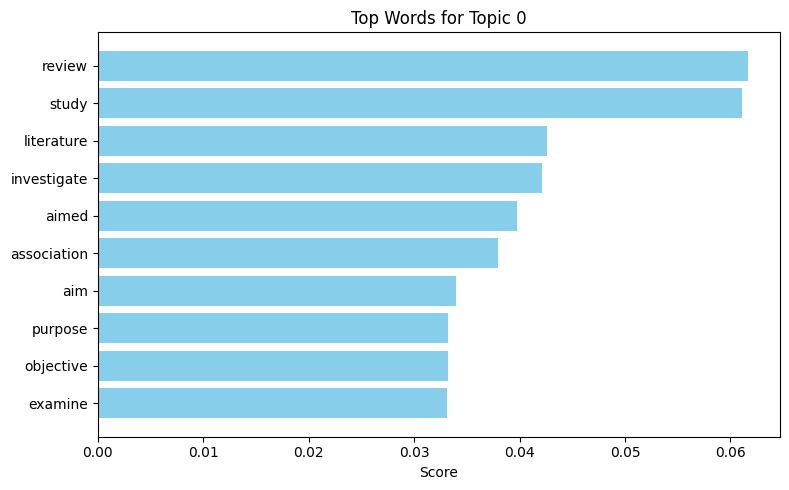

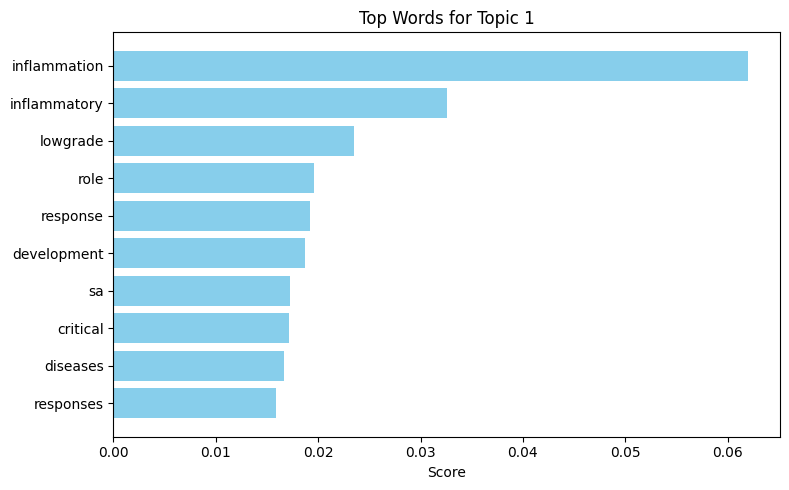

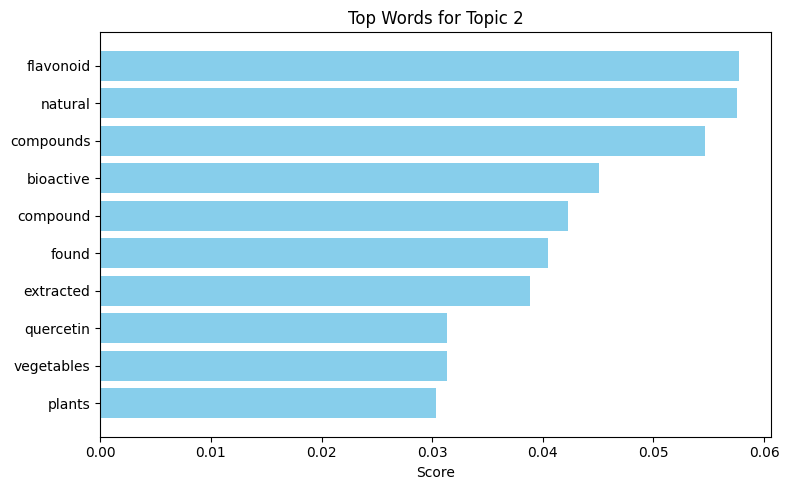

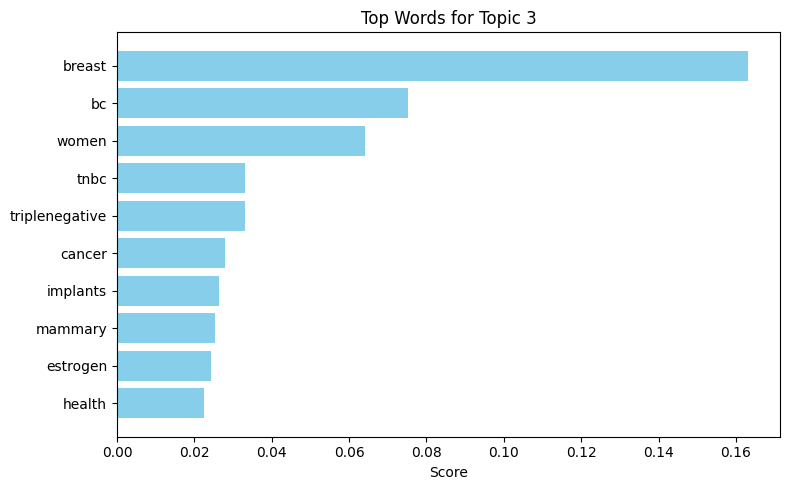

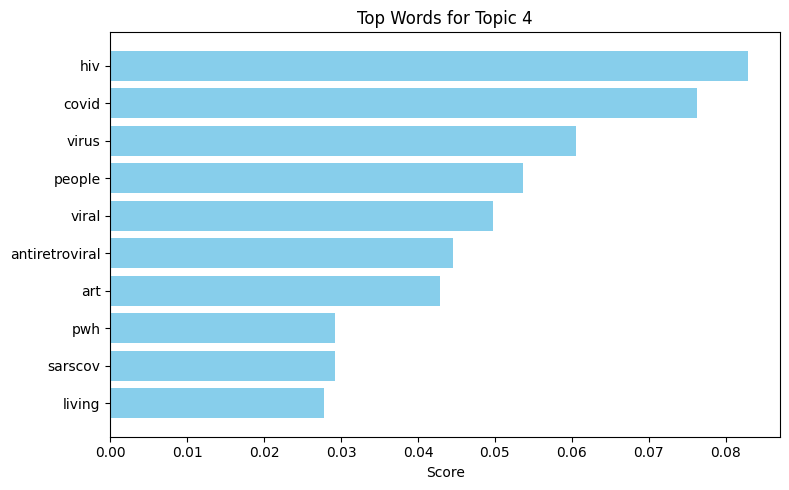

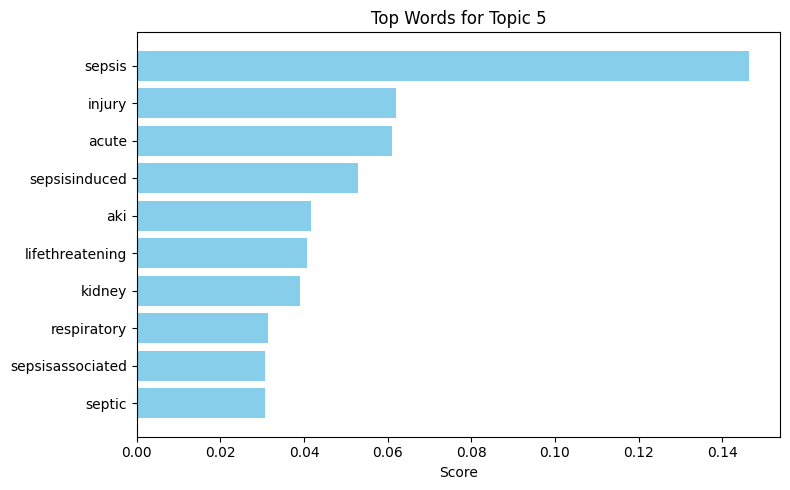

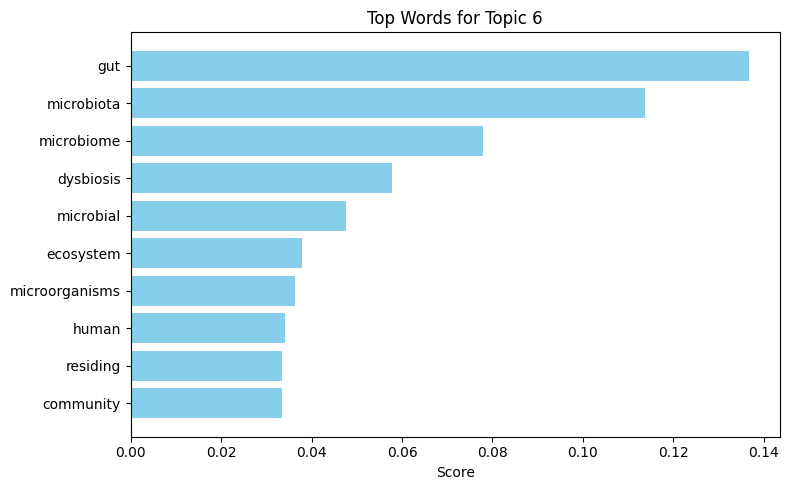

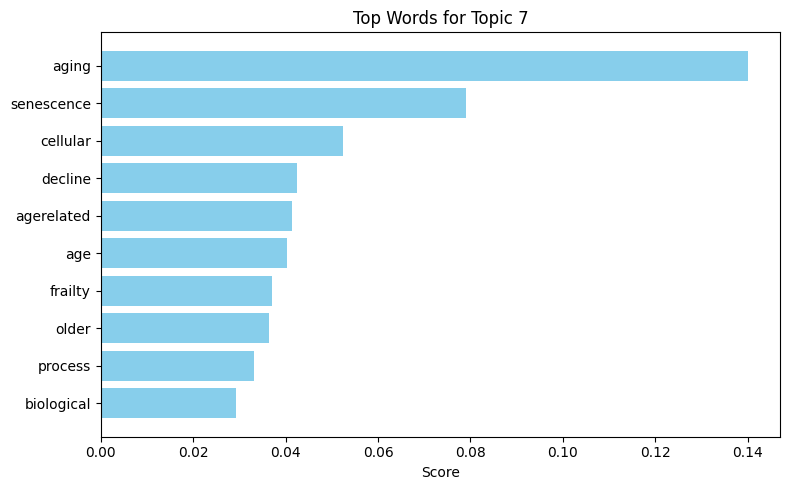

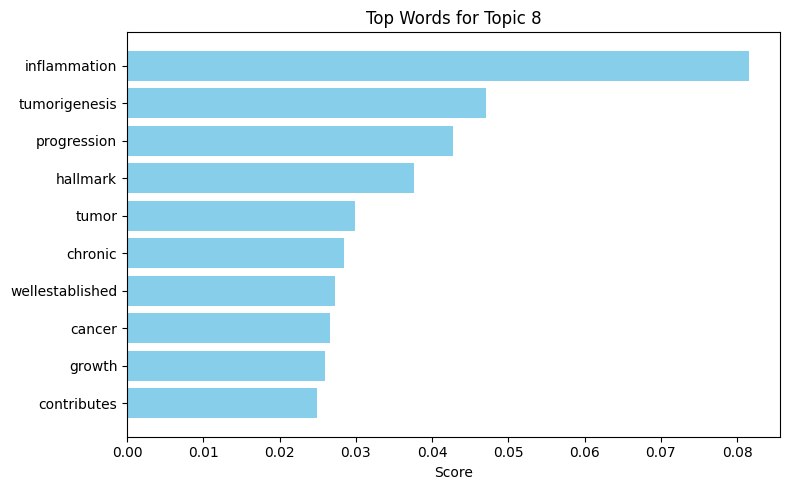

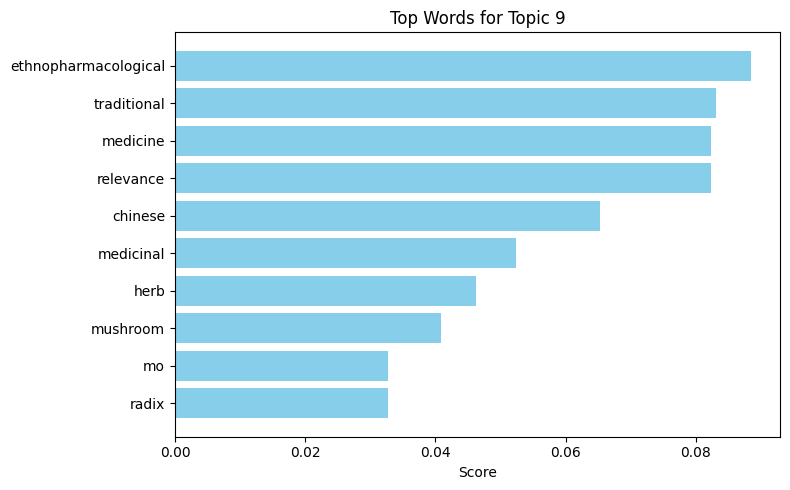

In [18]:
import matplotlib.pyplot as plt

# Loop through the first 10 topics
for topic_num in range(10):
    topic = topic_model.get_topic(topic_num)
    if topic:  # Check if topic exists
        words, scores = zip(*topic[:10])  # Top 10 words
        plt.figure(figsize=(8, 5))
        plt.barh(words[::-1], scores[::-1], color='skyblue')
        plt.xlabel("Score")
        plt.title(f"Top Words for Topic {topic_num}")
        plt.tight_layout()
        plt.show()


In [6]:
from bertopic import BERTopic
topic_model = BERTopic.load("bertopic_model")

2025-05-16 16:16:36.727172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747412196.756185     303 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747412196.765143     303 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Word Clouds

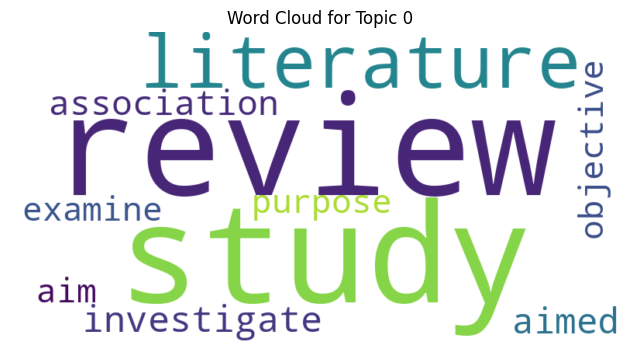

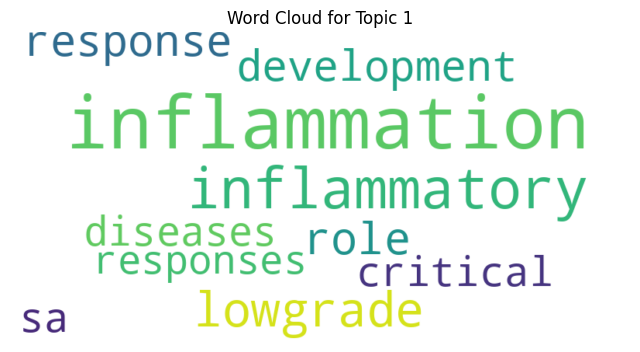

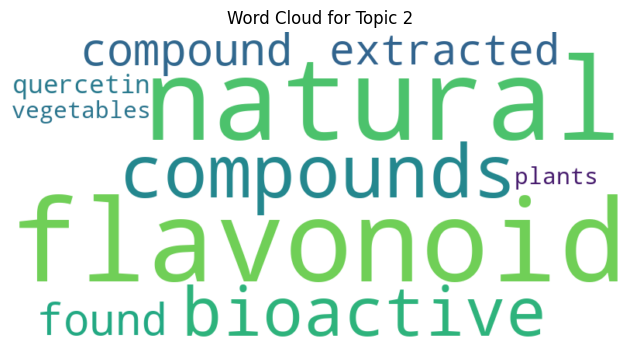

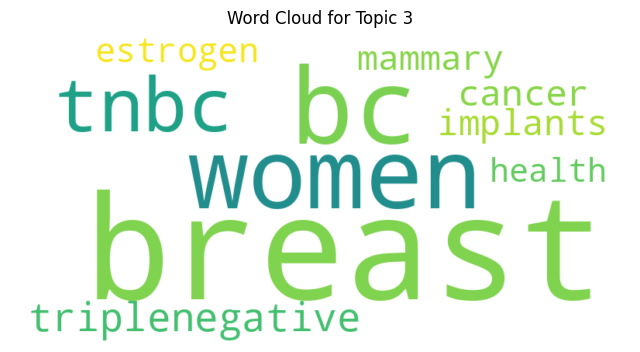

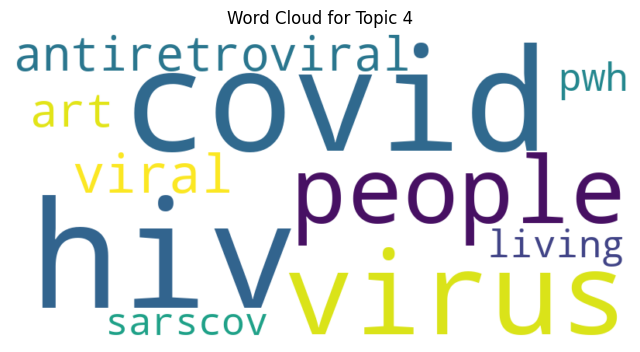

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get topics dictionary from BERTopic
topics = topic_model.get_topics()

# Plot word cloud for first 5 topics
for topic_num in range(5):
    plt.figure(figsize=(8, 6))
    
    # Create a dictionary of {word: score}
    word_freq = dict(topics[topic_num])
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(word_freq)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_num}")
    plt.show()


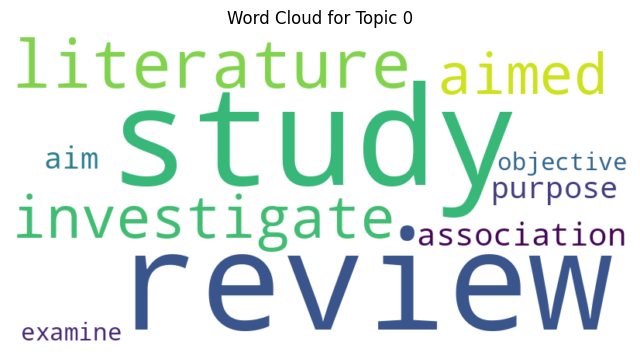

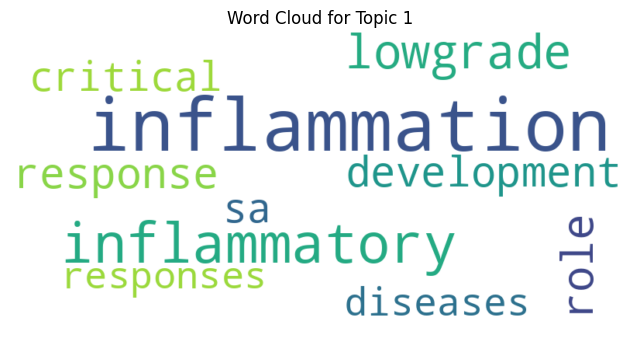

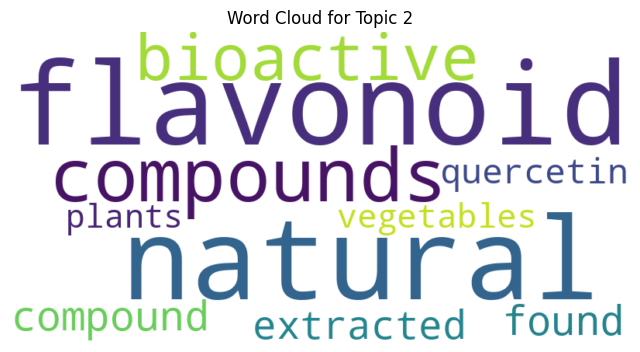

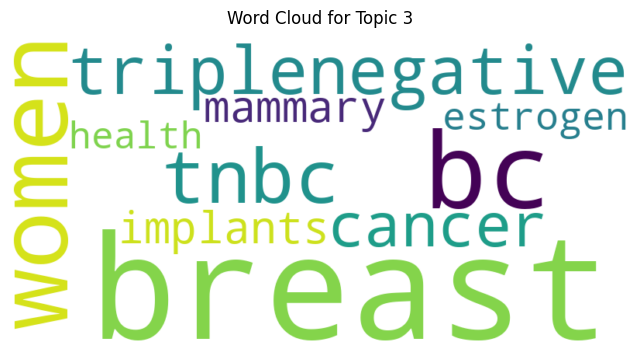

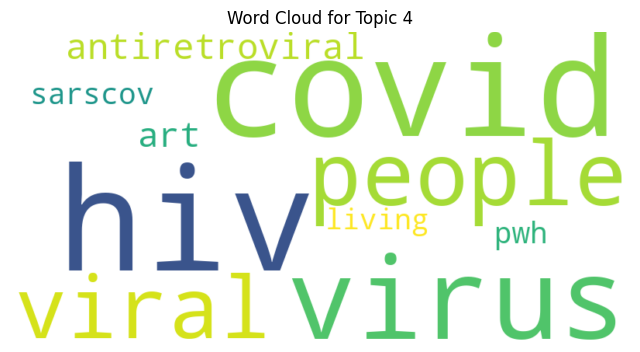

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get top 20 words per topic instead of default 10
topics = topic_model.get_topics()
topics = {k: v[:20] for k, v in topics.items()}

for topic_num in range(5):
    plt.figure(figsize=(8, 6))
    word_freq = dict(topics[topic_num])
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate_from_frequencies(word_freq)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_num}")
    plt.show()


In [14]:
topics_dict = topic_model.get_topics()  # returns dict {topic_id: [(word, score), ...]}

# For example, get top 20 words for topic 0 (or as many as available)
topic_0_words = topics_dict.get(0, [])[:50]
print(topic_0_words)


[('review', 0.061626017573186684), ('study', 0.06114951101286805), ('literature', 0.04262756486912741), ('investigate', 0.042126146345827745), ('aimed', 0.03980242766176968), ('association', 0.03799744444902692), ('aim', 0.03392994882601072), ('purpose', 0.03319070358513927), ('objective', 0.03318373755656314), ('examine', 0.033137842947048836)]


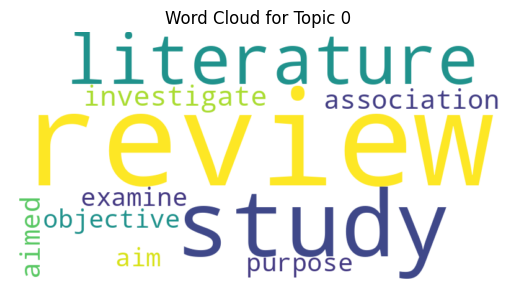

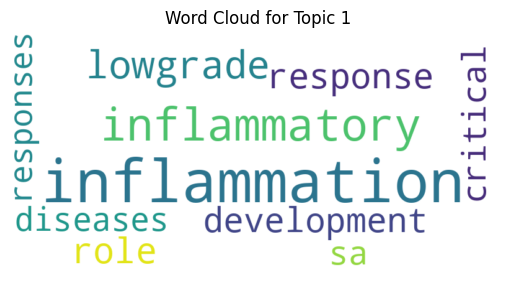

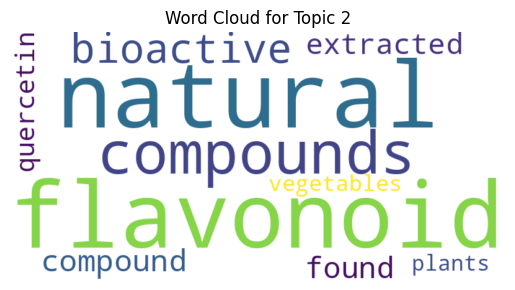

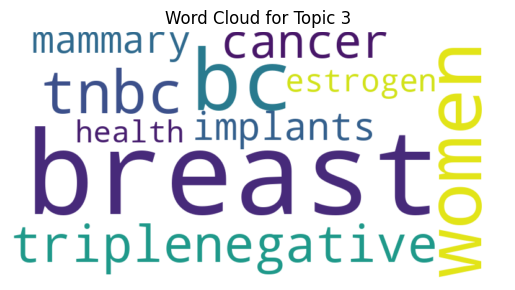

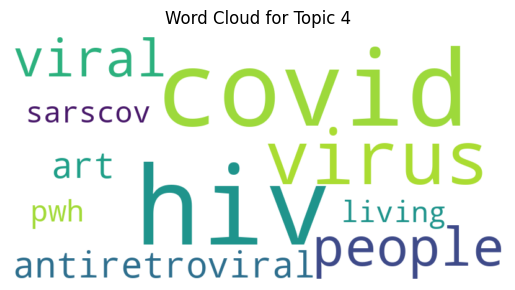

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

topics_dict = topic_model.get_topics()

for topic_num in range(5):  # first 5 topics
    words_scores = topics_dict.get(topic_num, [])[:20]  # top 20 words if available
    word_freq = {word: score for word, score in words_scores}
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate_from_frequencies(word_freq)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_num}")
    plt.show()


In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Get all topics and their words with scores
topics = topic_model.get_topics()

# Create and save word clouds for the first N topics (e.g., 10)
num_topics = 10

for topic_num in range(num_topics):
    words_freq = dict(topics[topic_num])  # Convert list of tuples to dict
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_num}")
    
    # Save the figure
    plt.savefig(f"topic_{topic_num}_wordcloud.png")
    plt.close()


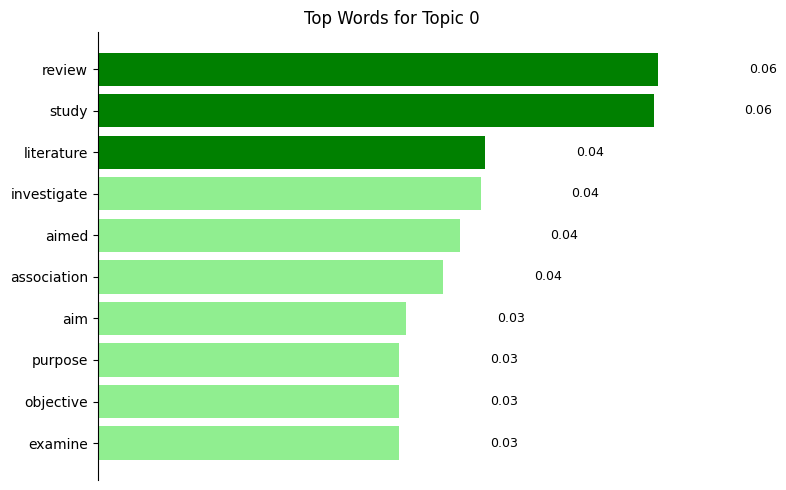

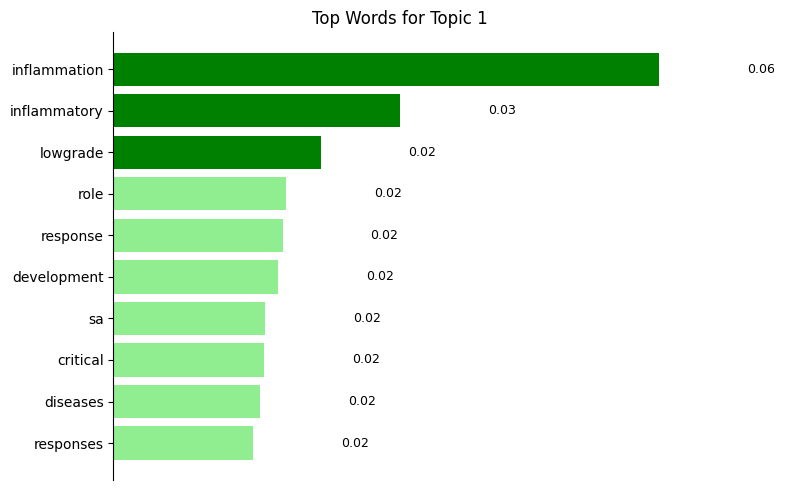

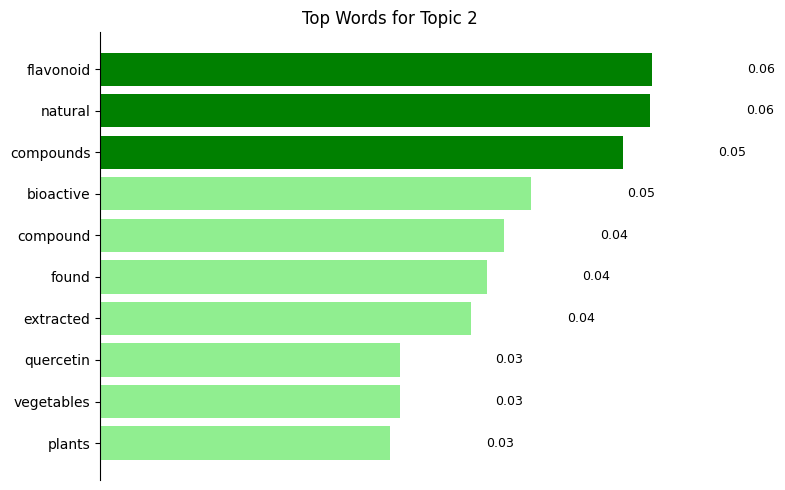

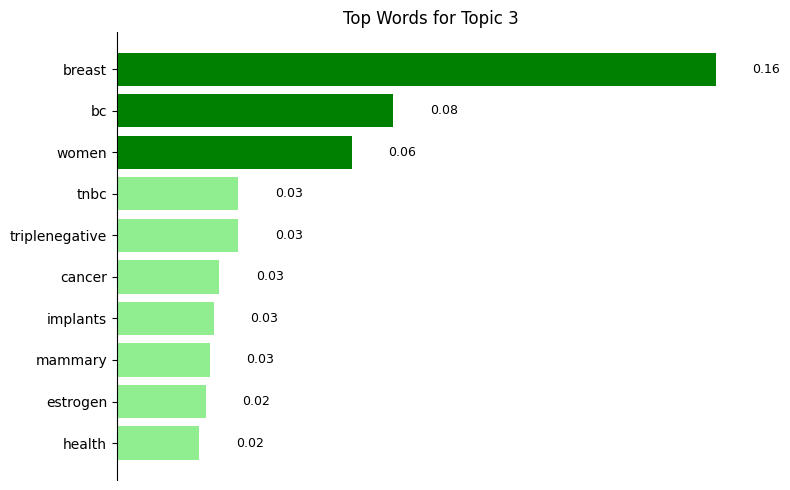

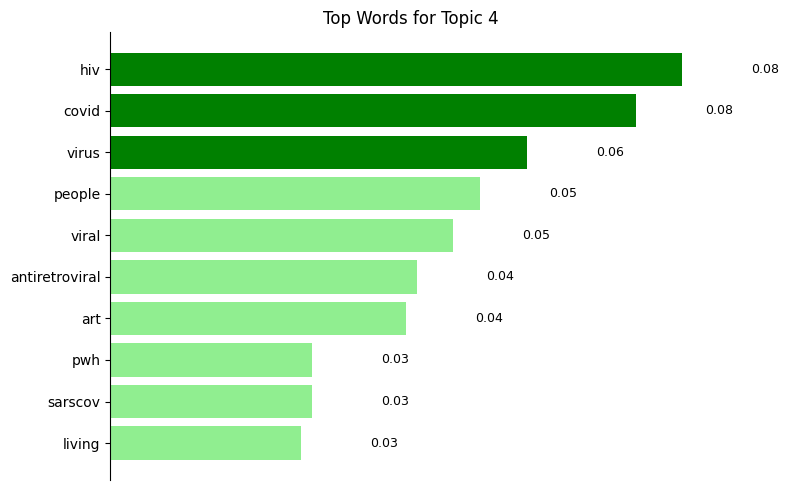

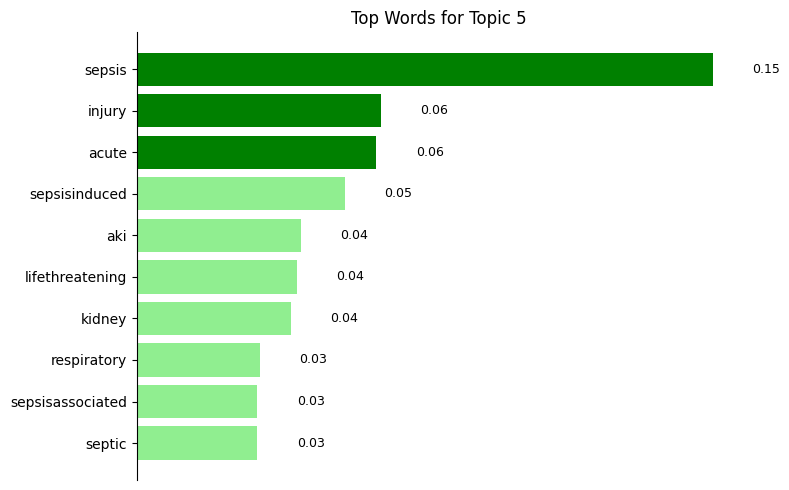

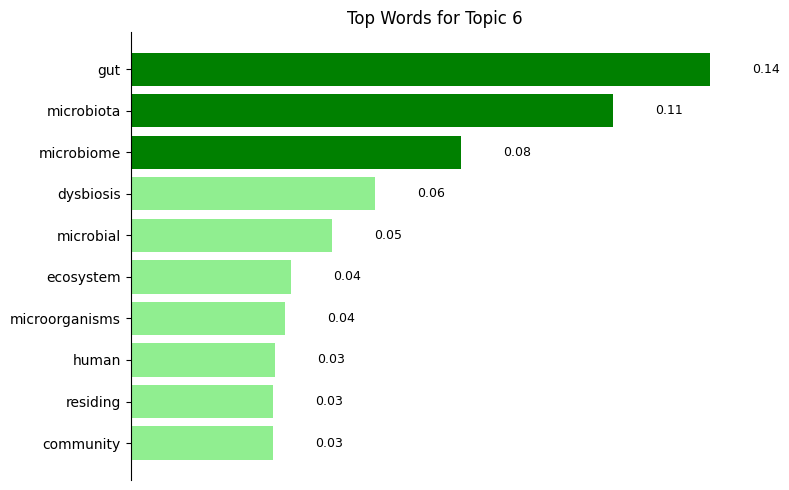

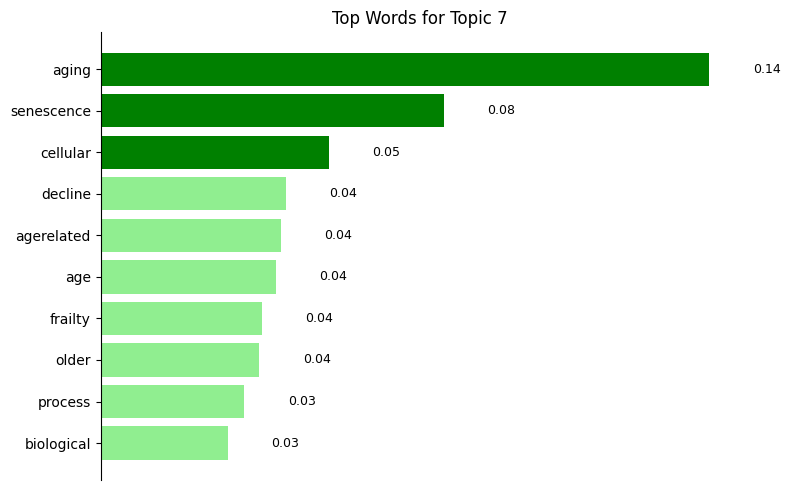

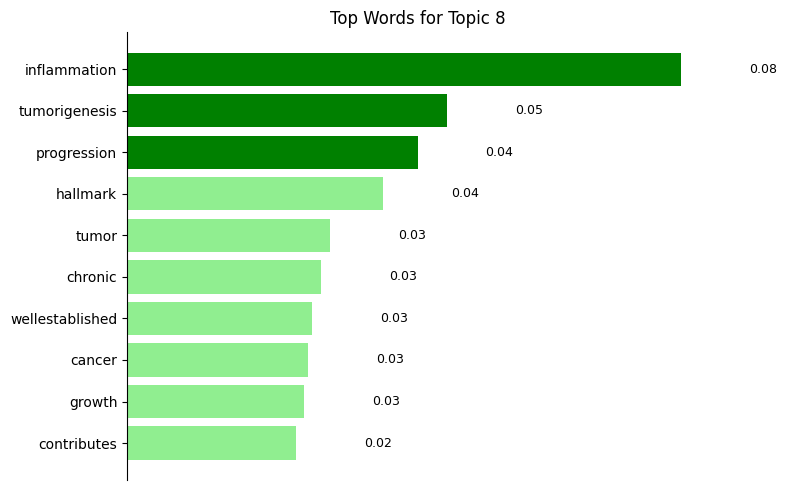

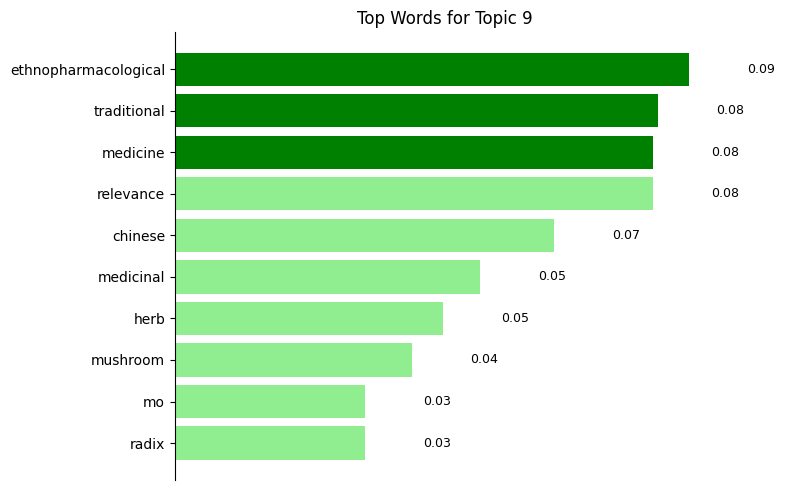

In [23]:
import matplotlib.pyplot as plt

for topic_num in range(10):
    topic = topic_model.get_topic(topic_num)
    if topic:
        words, scores = zip(*topic[:10])
        words, scores = list(words)[::-1], list(scores)[::-1]

        colors = ['lightgreen'] * 10
        for i in range(3):
            colors[-(i + 1)] = 'green'

        plt.figure(figsize=(8, 5))
        bars = plt.barh(range(len(words)), scores, color=colors)

        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                     f"{scores[i]:.2f}", va='center', fontsize=9)

        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)  # Hide bottom spine (x axis line)
        ax.spines['left'].set_visible(True)

        # Keep y-axis ticks and labels (words)
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words)

        # Remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])

        plt.xlabel("")  # Remove x-axis label text
        plt.title(f"Top Words for Topic {topic_num}")
        plt.tight_layout()
        plt.show()


In [25]:
import matplotlib.pyplot as plt

for topic_num in range(10):
    topic = topic_model.get_topic(topic_num)
    if topic:
        words, scores = zip(*topic[:10])
        words, scores = list(words)[::-1], list(scores)[::-1]

        colors = ['lightgreen'] * 10
        for i in range(3):
            colors[-(i + 1)] = 'green'

        plt.figure(figsize=(8, 5))
        bars = plt.barh(range(len(words)), scores, color=colors)

        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                     f"{scores[i]:.2f}", va='center', fontsize=9)

        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(True)

        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words)
        ax.set_xticks([])
        ax.set_xticklabels([])

        plt.xlabel("")
        plt.title(f"Top Words for Topic {topic_num}")
        plt.tight_layout()

        # Save the figure as PNG
        plt.savefig(f"topic_{topic_num}.png", dpi=300, bbox_inches='tight')
        plt.close()


In [26]:
import matplotlib.pyplot as plt

for topic_num in range(10):
    topic = topic_model.get_topic(topic_num)
    if topic:
        words, scores = zip(*topic[:10])
        words, scores = list(words)[::-1], list(scores)[::-1]

        colors = ['lightgreen'] * 10
        for i in range(3):
            colors[-(i + 1)] = 'green'

        plt.figure(figsize=(8, 5))
        bars = plt.barh(range(len(words)), scores, color=colors)

        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                     f"{scores[i]:.2f}", va='center', fontsize=13)  # +4 from 9

        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(True)

        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words, fontsize=14)  # +4 from 10
        ax.set_xticks([])
        ax.set_xticklabels([])

        plt.xlabel("", fontsize=14)  # +4 from 10
        plt.title(f"Top Words for Topic {topic_num}", fontsize=18)  # +4 from 14
        plt.tight_layout()

        # Save the figure as PNG
        plt.savefig(f"topic_{topic_num}.png", dpi=300, bbox_inches='tight')
        plt.close()


In [ ]:
# Save the model to a file
topic_model.save("bertopic_model")
